<a href="https://colab.research.google.com/github/dduwa/ocular-disease-recognition/blob/main/Augmented_Data_Resnet50_ODIR5K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
import os

from concurrent.futures import ThreadPoolExecutor


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading the Dataset

In [3]:
csv_path = '/content/drive/MyDrive/OcularDiseaseRecognitionSystem/Dataset/full_df.csv'
df_data = pd.read_csv(csv_path)
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


#Evaluating the first round of training of the ResNet 50 Model
- The model intially struggles with class imbalance since there are low accuracy rates with a bias towards classes with more data such as Normal, Other and Diabetes.
- Training accuracy improved over time but validation accuracy lagged suggesting overfitting. Loss decreased steadily, yet training and validation loss diverged.
- Model frequently misclassified minority classes (e.g., Diabetes as Normal). Therefore there is a need to implement class balance correction techniques for better model generalisation and performance.

**Below images related to these mentioned issues are displayed:**


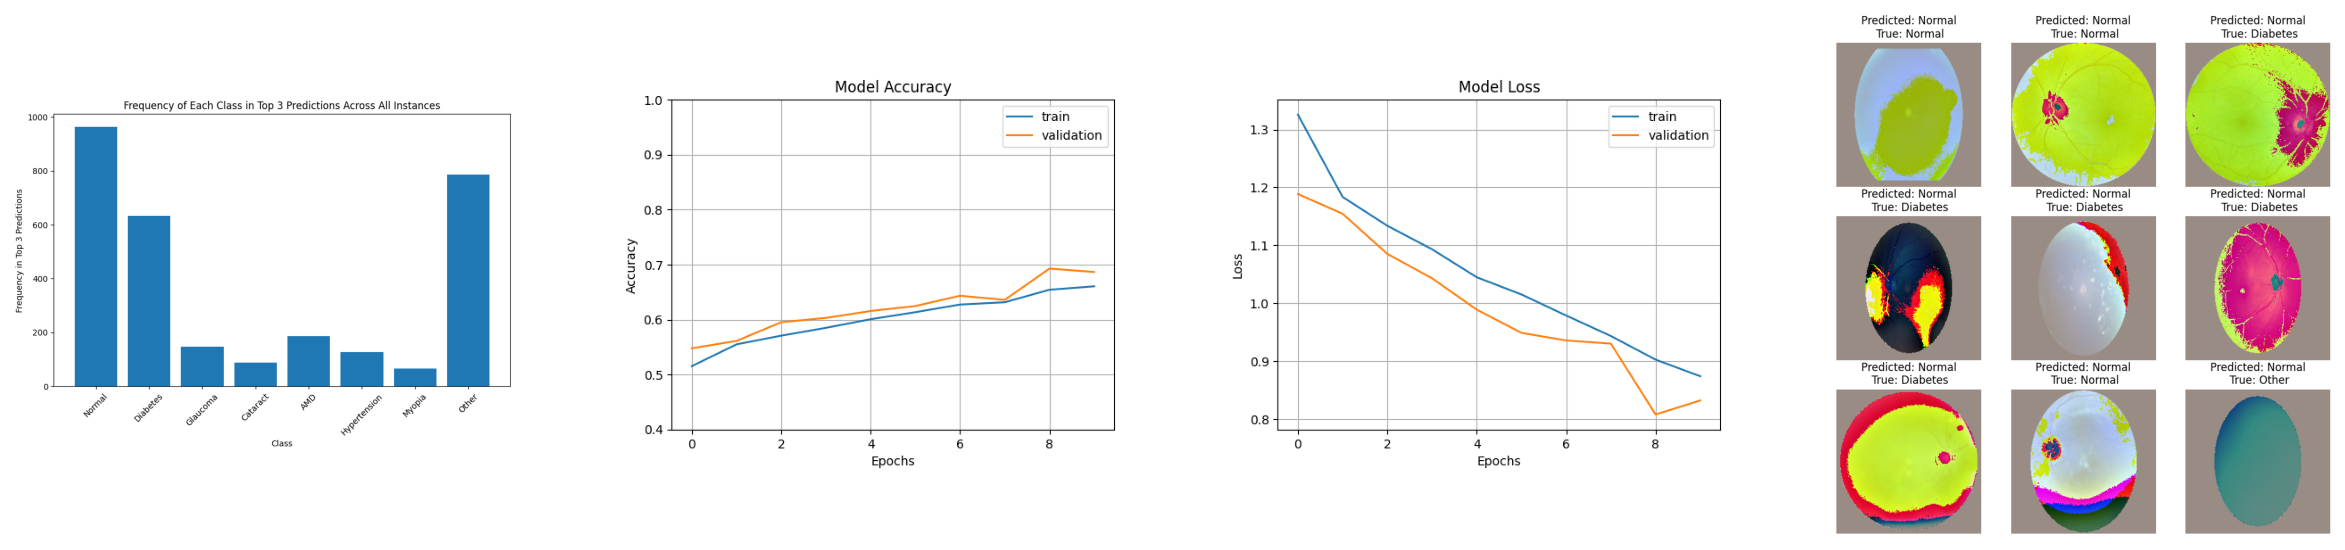

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(30,10))

pred_graph = plt.imread('/content/drive/MyDrive/OcularDiseaseRecognitionSystem/top3predictions.png')
axs[0].imshow(pred_graph)
axs[0].axis('off')

model_acc = plt.imread('/content/drive/MyDrive/OcularDiseaseRecognitionSystem/modelacc.png')
axs[1].imshow(model_acc)
axs[1].axis('off')

model_loss = plt.imread('/content/drive/MyDrive/OcularDiseaseRecognitionSystem/modelloss.png')
axs[2].imshow(model_loss)
axs[2].axis('off')

test_pred = plt.imread('/content/drive/MyDrive/OcularDiseaseRecognitionSystem/TestPred.png')
axs[3].imshow(test_pred)
axs[3].axis('off')

plt.show()

#Data Distribution
- Below is shown the distribution of images available for each different ocular condition. The different diseases are encoded into individual coloums as N (Normal), D (Diabetes), G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia), O (Other diseases/abnormalities). They have binary indicators 0 or 1 to specify the absence or presence of a condition. This is also know as one-hot encoding. Thus, the dataset structure indicates multiple labels per image, allowing for multi-label classifcation.

- Conditions G, C, A, H and M are minority classes since they have low image samples, causing class imbalance.

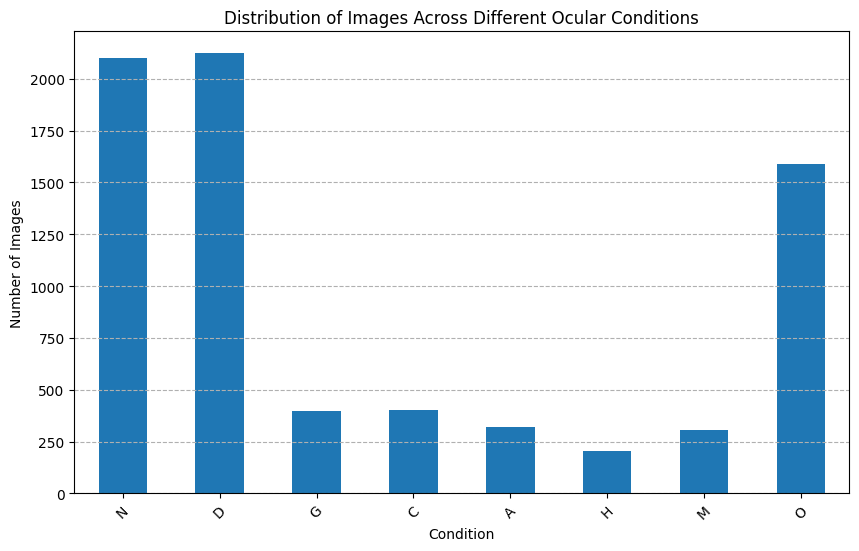

In [5]:
# Sum up the occurrences of each condition
class_counts = df_data[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].sum()

# Plotting
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Images Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()

In [6]:
class_distribution = df_data[['N','D','G', 'C', 'A', 'H', 'M', 'O']].sum()
print(class_distribution)

N    2101
D    2123
G     397
C     402
A     319
H     203
M     306
O    1588
dtype: int64


#Loading and Visualising the Minority Class Dataset
- This dataset will include images from the training data that are classified as any of the minority classes -  G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia), O (Other diseases/abnormalities)

In [10]:
from concurrent.futures import ThreadPoolExecutor
from tqdm.auto import tqdm
import ast
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [5]:
def string_to_float_list(target_string):
    list_of_ints = ast.literal_eval(target_string)
    # Convert the list of integers to a list of floats
    return [float(x) for x in list_of_ints]

In [6]:
minority_class_counts= df_data[['G', 'C', 'A', 'H', 'M']].sum()
print(minority_class_counts)

G    397
C    402
A    319
H    203
M    306
dtype: int64


In [7]:
# List of minority classes
minority_classes = ['G', 'C', 'A', 'H', 'M']

# Efficient DataFrame filtering
mask = df_data[minority_classes].sum(axis=1) > 0
df_data_minority = df_data[mask]

# Initialize ImageDataGenerator for augmentation
augmentation = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=50,
    fill_mode='nearest'
)

# Function to load and preprocess images
def load_process_minority_image(file_path, label):
    if os.path.exists(file_path):
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = tf.keras.applications.resnet50.preprocess_input(img)
        label_list = string_to_float_list(label)  # Assuming this function is defined elsewhere
        label = tf.convert_to_tensor(label_list, dtype=tf.float32)
        return img, label
    return None, None


In [8]:
def augment_and_process_images_to_disk(df_data_minority, minority_classes, images_path, save_dir, per_class_limit=2000):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    class_image_counts = {cls: 0 for cls in minority_classes}
    total_augmented_per_class = {cls: 0 for cls in minority_classes}

    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = []
        for _, row in tqdm(df_data_minority.iterrows(), total=df_data_minority.shape[0], desc='Loading images'):
            for eye_side in ['Left-Fundus', 'Right-Fundus']:
                if row[eye_side]:
                    image_path = os.path.join(images_path, row[eye_side])
                    futures.append(executor.submit(load_process_minority_image, image_path, row['target']))

        for future in tqdm(futures, desc='Processing images'):
            img, label = future.result()
            if img is not None and label is not None:
                label_array = label.numpy()

                try:
                    label_indices = [i for i, lbl in enumerate(label_array) if lbl == 1 and i < len(minority_classes)]
                    if all(total_augmented_per_class[minority_classes[i]] < per_class_limit for i in label_indices):
                        for _ in range(5):
                            if sum(total_augmented_per_class.values()) >= per_class_limit * len(minority_classes):
                                break  # Global limit reached, stop processing
                            augmented_img = augmentation.random_transform(img)
                            # Save augmented images to disk
                            for i in label_indices:
                                class_name = minority_classes[i]
                                save_path = os.path.join(save_dir, class_name)
                                if not os.path.exists(save_path):
                                    os.makedirs(save_path)
                                img_filename = f"{class_name}_{total_augmented_per_class[class_name]:04d}.png"
                                save_img(os.path.join(save_path, img_filename), augmented_img)
                                total_augmented_per_class[class_name] += 1
                except IndexError:
                    print("An index error occurred. Please check label indices and class mappings.")

    # Update final class counts
    final_class_image_counts = {cls: total_augmented_per_class[cls] for cls in minority_classes}

    return final_class_image_counts

# Specify the directory where augmented images will be saved
save_dir = '/content/drive/MyDrive/OcularDiseaseRecognitionSystem/Dataset/ODIR-5K/AugmentedImages'
total_image_limit = 2000
images_path = '/content/drive/MyDrive/OcularDiseaseRecognitionSystem/Dataset/ODIR-5K/TrainingImages'
# Execute the function and save images to disk
class_image_counts = augment_and_process_images_to_disk(df_data_minority, minority_classes, images_path, save_dir, total_image_limit)

# Print class counts
print("Image counts per class after augmentation:")
for cls, count in class_image_counts.items():
    print(f"{cls}: {count}")

Loading images:   0%|          | 0/1557 [00:00<?, ?it/s]

Processing images:   0%|          | 0/3114 [00:00<?, ?it/s]

Image counts per class after augmentation:
G: 1400
C: 1450
A: 2000
H: 2000
M: 2000


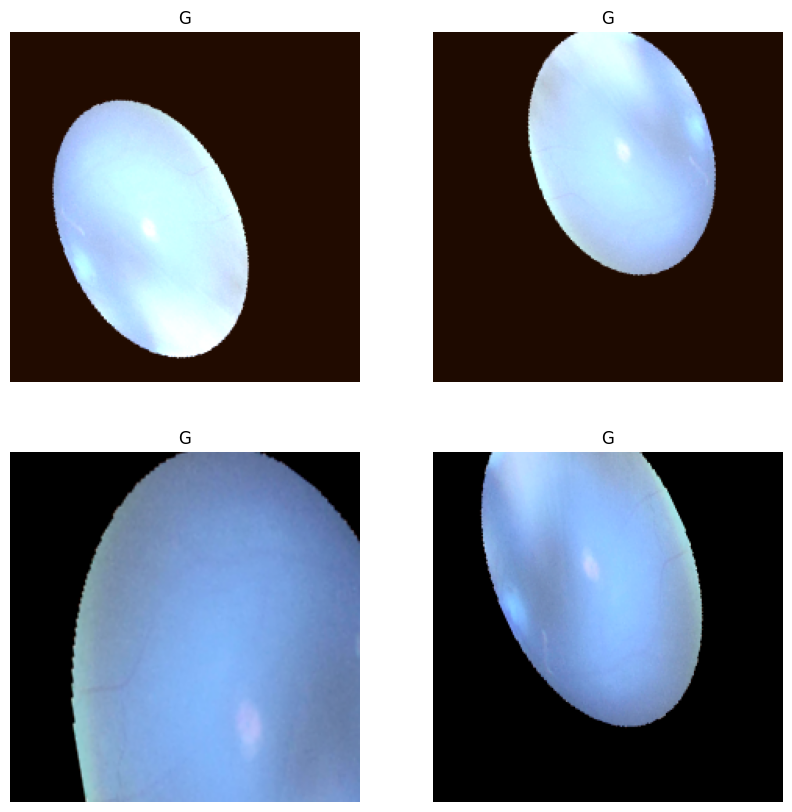

In [11]:
# Directory where the images are stored
base_dir = save_dir = '/content/drive/MyDrive/OcularDiseaseRecognitionSystem/Dataset/ODIR-5K/AugmentedImages'

# List of class names, assuming subdirectories are named after classes
minority_classes = ['G', 'C', 'A', 'H', 'M']

# Function to load a single image
def load_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    return img

# Function to load images and labels from directories
def load_images_from_directory(base_dir, minority_classes, num_images=4):
    images = []
    labels = []
    for cls in minority_classes:
        class_dir = os.path.join(base_dir, cls)
        if not os.path.isdir(class_dir):
            continue
        for img_name in os.listdir(class_dir)[:num_images]:  # Load only 'num_images' images per class
            img_path = os.path.join(class_dir, img_name)
            img = load_image(img_path)
            images.append(img)
            labels.append(cls)  # Using class name directly as label
            if len(images) >= num_images:
                break
        if len(images) >= num_images:
            break
    return np.array(images), labels

# Load images and labels
images, labels = load_images_from_directory(base_dir, minority_classes, 4)

# Plotting the images
plt.figure(figsize=(10, 10))
for i in range(len(images)):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].astype('uint8'))
    plt.title(labels[i])
    plt.axis('off')

plt.show()

# Loading and Visualising the majority classes

In [13]:
# Directory where processed images will be saved
processed_images_dir = '/content/drive/MyDrive/OcularDiseaseRecognitionSystem/Dataset/ODIR-5K/ProcessedMajorityImages'
if not os.path.exists(processed_images_dir):
    os.makedirs(processed_images_dir)

images_path = '/content/drive/MyDrive/OcularDiseaseRecognitionSystem/Dataset/ODIR-5K/TrainingImages'
majority_classes = ['N', 'D','O']


# Optimized DataFrame filtering
mask = df_data[majority_classes].sum(axis=1) > 0
df_data_majority = df_data[mask]

def save_processed_majority_image(file_path, label, save_dir):
    """
    Process and save the image to the specified directory.
    """
    if os.path.exists(file_path):
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = tf.keras.applications.resnet50.preprocess_input(img)
        label_list = string_to_float_list(label)  # Assume this function is defined
        label_tensor = tf.convert_to_tensor(label_list, dtype=tf.float32)
        # Generate a unique filename for the image
        base_filename = os.path.basename(file_path)
        save_filename = f"processed_{base_filename}"
        save_path = os.path.join(save_dir, save_filename)
        save_img(save_path, img)
        return save_path, label_tensor.numpy()  # Return path and label
    return None, None

def process_images_concurrently_and_save(df, classes, image_path, save_dir):
    """
    Process images concurrently and save them to disk.
    """
    saved_paths = []
    labels = []
    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = []
        for _, row in tqdm(df.iterrows(), total=df.shape[0], desc='Processing images'):
            for side in ['Left-Fundus', 'Right-Fundus']:
                if row[side] and any(row[cls] == 1 for cls in classes):
                    file_path = os.path.join(image_path, row[side])
                    futures.append(executor.submit(save_processed_majority_image, file_path, row['target'], save_dir))

        for future in tqdm(futures, total=len(futures), desc='Collecting results'):
            result = future.result()
            if result:
                saved_paths.append(result[0])
                labels.append(result[1])

    return saved_paths, labels

# Execute the function and save images and labels to disk
saved_paths, labels = process_images_concurrently_and_save(df_data_majority, majority_classes, images_path, processed_images_dir)

Processing images:   0%|          | 0/5315 [00:00<?, ?it/s]

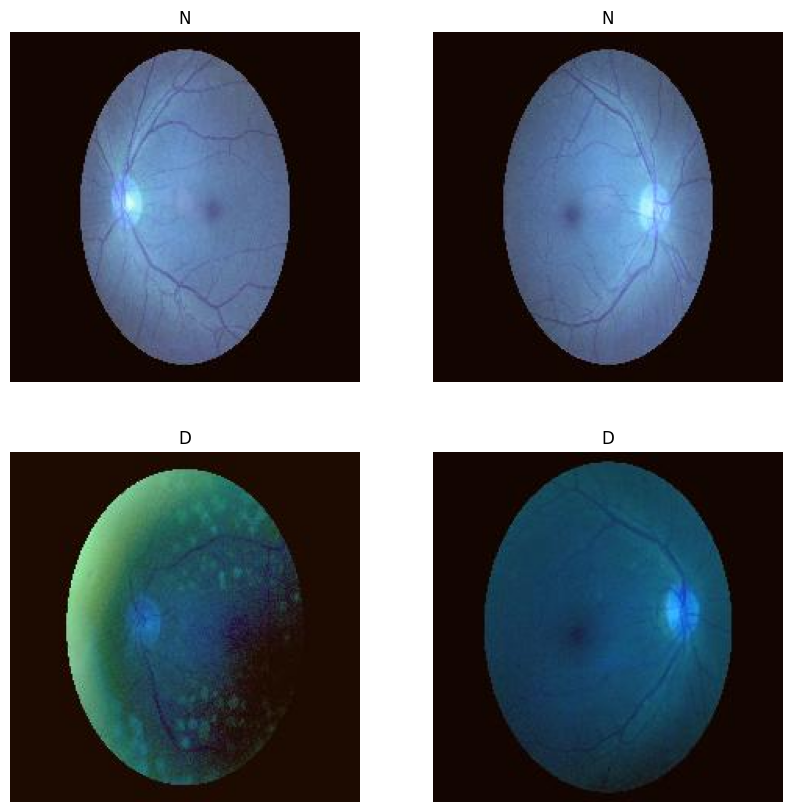

In [14]:
# Function to load images for visualization
def load_images_for_visualization(image_paths):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=(224, 224))
        img = np.array(img)
        images.append(img)
    return images

# Assuming `saved_paths` contains the paths to the saved images
# and `labels` contains the corresponding labels in the same order

# Load a few images for visualization (the first 4 in this example)
image_paths_sample = saved_paths[:4]
images = load_images_for_visualization(image_paths_sample)

# Assuming `labels` is a list of numpy arrays and `majority_classes` is defined
# If `labels` is not in the expected format, adjust the label extraction logic accordingly

plt.figure(figsize=(10, 10))

for i in range(len(images)):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].astype('uint8'))

    # Assuming labels are stored in a compatible format
    # If labels are one-hot encoded, find the class name using argmax
    # Adjust the following line if your label format differs
    label_index = np.argmax(labels[i])
    class_name = majority_classes[label_index]

    plt.title(class_name)
    plt.axis('off')

plt.show()

In [ ]:
images_path = '/content/drive/MyDrive/OcularDiseaseRecognitionSystem/Dataset/ODIR-5K/TrainingImages'
majority_classes = ['N', 'D','O']

# Assuming df_data and other necessary imports and functions are defined, such as `string_to_float_list`

# Optimized DataFrame filtering
mask = df_data[majority_classes].sum(axis=1) > 0
df_data_majority = df_data[mask]

majority_images, majority_labels = [], []

def load_process_majority_image(file_path, label):
    if os.path.exists(file_path):
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = tf.keras.applications.resnet50.preprocess_input(img)
        label_list = string_to_float_list(label)  # Assume this function is defined
        label = tf.convert_to_tensor(label_list, dtype=tf.float32)
        return img, label
    return None, None

def handle_majority_image_result(result):
    img, label = result
    if img is not None and label is not None:
        majority_images.append(img)
        majority_labels.append(label)

# Process images concurrently
def process_images_concurrently(df, classes, image_path):
    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = []
        for _, row in tqdm(df.iterrows(), total=df.shape[0], desc='Processing images'):
            for side in ['Left-Fundus', 'Right-Fundus']:
                if row[side] and any(row[cls] == 1 for cls in classes):
                    file_path = os.path.join(image_path, row[side])
                    futures.append(executor.submit(load_process_majority_image, file_path, row['target']))

        for future in tqdm(futures, total=len(futures), desc='Collecting results'):
            handle_majority_image_result(future.result())

process_images_concurrently(df_data_majority, majority_classes, images_path)

# Convert lists to NumPy arrays
majority_images = np.array(majority_images)
majority_labels = np.array(majority_labels)

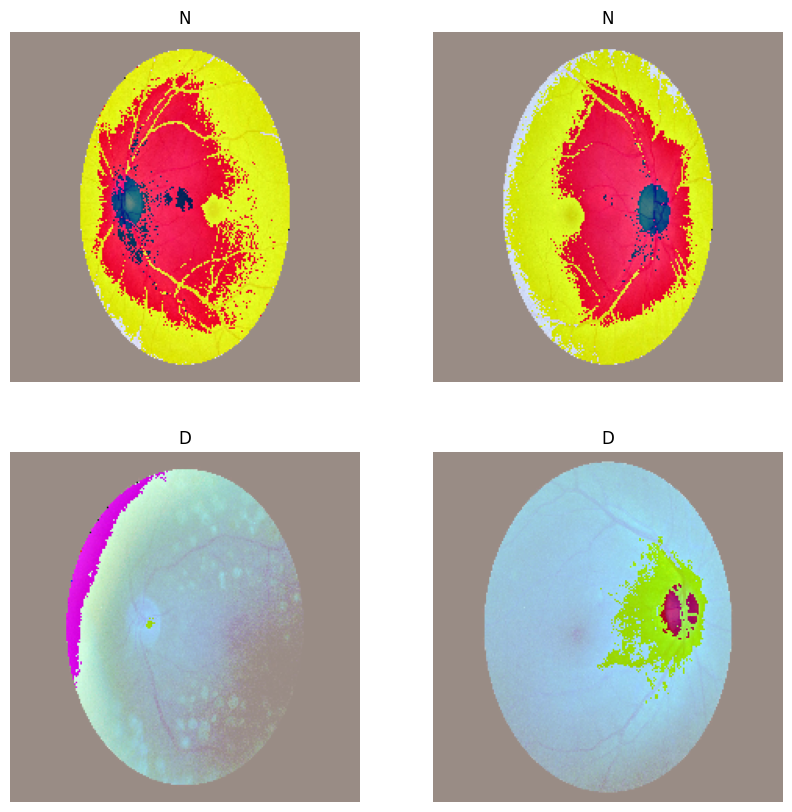

In [11]:
# Plot the images
plt.figure(figsize=(10,10))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(majority_images[i].astype('uint8'))
     # Get the label index
    label_index = np.argmax(majority_labels[i])
    # Map the label index to the corresponding class name
    class_name = majority_classes[label_index]
    plt.title(class_name)
    plt.axis('off')


# Join together the minority and majority images and labels

In [15]:
# join the minority and majority images and labels
images = np.concatenate((minority_images, majority_images), axis=0)
labels = np.concatenate((minority_labels, majority_labels), axis=0)

NameError: name 'minority_images' is not defined

#Preparing augmentated data for training
- Splitting the augmented data into training and validation sets.

In [ ]:
# Create a tf.data.Dataset
image_ds = tf.data.Dataset.from_tensor_slices((images, labels))

# Shuffle the dataset
image_ds = image_ds.shuffle(buffer_size=len(images))

# Split the dataset into training and validation sets
train_size = int(0.8 * len(images))
train_ds = image_ds.take(train_size)
val_ds = image_ds.skip(train_size)

# Batch the datasets
batch_size = 16
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

# Prefetch the datasets
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
print("size of training dataset: ", len(train_ds))
print("size of validation dataset: ", len(val_ds))

# Visualising the training and validation datasets




In [ ]:
print("Training dataset")
for images, labels in train_dataset.take(1):
    print(images.shape)
    print(labels.shape)


# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(labels[i].numpy())
    plt.axis("off")


In [ ]:
print("Validation dataset")
for images, labels in val_dataset.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(labels[i].numpy())
    plt.axis("off")

# Training the model

In [ ]:
resnet_50_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg', classes=8,
    weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_50_model.add(pretrained_model)
resnet_50_model.add(Flatten())
resnet_50_model.add(Dense(512, activation='relu'))
resnet_50_model.add(Dense(8, activation='softmax'))

In [ ]:
resnet_50_model.summary()

In [ ]:
resnet_50_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 10
history = resnet_50_model.fit(train_ds, validation_data=val_ds, epochs=epochs)

# Evaluating Model
- Model Accuracy
- Model Loss


In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Loading Test Data

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path

# Define the parse_image function
def parse_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocessing the image to be compatible with ResNet50
    return image

# Specify the directory
data_dir = Path('ODIR-5K/')
test_image_paths = list(data_dir.glob('Testing Images/*'))

# Convert the list of image paths to strings (if they're not already)
test_image_paths = [str(path) for path in test_image_paths]

# Create a TensorFlow dataset from the list of image paths
test_dataset = tf.data.Dataset.from_tensor_slices(test_image_paths)

# Map the parse_image function to preprocess the images
test_dataset = test_dataset.map(parse_image)

# Apply batching and prefetching to the dataset
test_dataset = test_dataset.batch(32)  # Batching
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)  # Prefetching

# Visualize the data
plt.figure(figsize=(10, 10))
for images in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy() / 255)
        plt.axis('off')


In [ ]:
print("Size of test dataset: ", len(test_dataset))

Making Predictions

In [ ]:
# Evaluate the model on the test dataset
resnet_50_model.evaluate(test_dataset)

# Generate predictions
predictions = resnet_50_model.predict(test_dataset)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)


# Plot the first 9 images, their predicted labels, and the true labels
output_class=class_labels[np.argmax(predicted_classes[i])]
plt.figure(figsize=(10, 10))

for i, image in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0] / 255)
    plt.title("Predicted: {}\n True: {}".format(output_class, class_labels[np.argmax(labels[i])]))
    plt.axis("off")

# Prediction Analysis

In [ ]:
# Make predictions on the test dataset
predictions = resnet_50_model.predict(test_dataset)

# Define class labels
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(9, 2, figsize=(10, 20))  # 9 rows, 2 columns

# Use unbatched dataset for iteration and take the first 9 images
test_dataset_unbatched = test_dataset.unbatch().take(9)

for i, (image, prediction) in enumerate(zip(test_dataset_unbatched, predictions)):
    # First column: the images
    axes[i, 0].imshow(image.numpy().astype("uint8"))
    axes[i, 0].axis('off')  # Hide the axes
    axes[i, 0].set_title(f'Image {i + 1}')

    # Second column: the bar plots for top 3 predictions
    top3_indices = prediction.argsort()[-3:][::-1]
    top3_labels = [class_labels[idx] for idx in top3_indices]
    top3_probs = prediction[top3_indices]

    axes[i, 1].bar(top3_labels, top3_probs, color='skyblue')
    axes[i, 1].set_ylim(0, 1)  # Probabilities range from 0 to 1
    axes[i, 1].set_title('Top 3 Predictions')

plt.tight_layout()
plt.show()